<a href="https://colab.research.google.com/github/victorviro/Deep_learning_python/blob/master/Improving_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object detection

In a previous notebook we saw an [Introduction to object detection](https://github.com/victorviro/Deep_learning_python/blob/master/Introduction_to_object_detection.ipynb). We saw that modern object detectors are usually composed of two parts, a backbone which is usually pre-trained on ImageNet (or in a similar dataset) and a head which is used to predict classes and bounding boxes of objects. The backbone refers to the network which takes as input the image and extracts the features maps. It could be VGG, ResNet, ResNeXt, etc. The head part is usually categorized into two kinds, i.e., one-stage object detector and two-stage object detector. One-stage object detectors takes only one forward propagation pass through the network to make the predictions and they are usually faster than two-stage detectors but they usually have less accuracy. The most representative one-stage object detectors are *You Only Look Once* ([YOLOv1](https://arxiv.org/abs/1506.02640), [YOLOv2](https://arxiv.org/abs/1612.08242), [YOLOv3](https://arxiv.org/abs/1804.02767), [YOLOv4](https://arxiv.org/abs/2004.10934)), *Single Shot MultiBox Detector* ([SSD](https://arxiv.org/abs/1512.02325)) ,and [RetinaNet](https://arxiv.org/abs/1708.02002). As for two-stage object detector, the most representative models are the [R-CNN](https://arxiv.org/abs/1311.2524) series (including [fast R-CNN](https://arxiv.org/abs/1504.08083), [faster R-CNN](https://arxiv.org/abs/1506.01497) and [R-FCN](https://arxiv.org/abs/1605.06409)). Object detectors developed in recent years often insert some layers between backbone and head, and these layers are usually used to collect feature maps from different stages. We can call it the *neck* of an object detector. It is directly leveraged into backbones for enhancing the richness and semantic representation of extracted features for objects of different shapes and sizes. Usually, a neck is composed of several bottom-up paths and several top-down paths. Networks equipped with this mechanism include *Feature Pyramid Network* ([FPN](https://arxiv.org/abs/1612.03144)) or *Path Aggregation Network* ([PAN](https://arxiv.org/abs/1803.01534)).


To sum up, object detectors tipically are compose of several components:

![texto alternativo](https://i.ibb.co/Vw3sLBQ/object-detector-arquitecture.png)

![texto alternativo](https://i.ibb.co/LN2vn7q/object-detection-flow.png)






Apart from different selective approaches in architecture designs, the are also optimization procedures which can to be used at the time of training and inference. 

- Conventional object detectors are train off-line. Therefore, we can develop object detection models which have better accuracy without increasing the inference cost. These methods that only increase the training cost are called *bag of freebies* (BoF) in some recent papers.

- By other hand, plugin modules and post-processing methods that only increase the inference cost by a small amount but can significantly improve the accuracy of object detection are called *bag of specials* (BoS). Generally speaking, these plugin modules are for enhancing certain attributes in a model, such as enlarging receptive field, introducing attention mechanism, or strengthening feature integration capability, etc.

## Bag of freebies


### Data augmentation

 A common method is data augmentation whose purpose is to increase the variability of the input images, so that the designed object detection model has higher robustness to the images obtained from different environments. For examples, photometric distortions (rightness, contrast, hue or saturation) and geometric distortions (random scaling, cropping, flipping, or rotating) are two commonly used data augmentation methods and they benefit the object detection task. In these methods, all original pixel information in the adjusted area is retained. In addition, some researchers engaged in data augmentation put their emphasis on simulating object occlusion issues getting good results in image classification and object detection. For example, [random erase](https://arxiv.org/abs/1708.04896) can randomly select the rectangle region in an image and fill in a random value.

![texto alternativo](https://i.ibb.co/rGNKmFB/random-erasin-object-detection.png)




[CutOut](https://arxiv.org/abs/1708.04552) can randomly select the rectangle region in an image and fill in a complementary value of zero.
As for [hide-and-seek](https://arxiv.org/abs/1811.02545) (HaS) and [grid mask](https://arxiv.org/abs/2001.04086), they randomly or evenly select multiple rectangle regions in an image and replace them to all zeros. 
 
![texto alternativo](https://i.ibb.co/SwVP8rD/gridmask-data-aug.png)
 
In addition, some researchers have proposed the methods of using multiple images together to perform data augmentation.  For example, [MixUp](https://arxiv.org/abs/1710.09412) uses two images to multiply and superimpose with different coefficient ratios, and then adjusts the label with these superimposed ratios. 

![texto alternativo](https://i.ibb.co/YcCYw9F/mix-Up-object-detection.png)

As for [CutMix](https://arxiv.org/abs/1905.04899), it is to cover the cropped image to rectangle region of other images, and adjusts the label according to the size of the mix area. 

![texto alternativo](https://i.ibb.co/5BhTdfp/mixuo-cutout-cutmix.png)

In [YOLOv4 paper](https://arxiv.org/abs/2004.10934), a new data augmentation method called *moscaic* was introduced, which mixes 4 training images. 

![texto alternativo](https://i.ibb.co/BVnz3hN/mosaic-data-augm.png)

In  addition to the above mentioned methods, [style transfer GAN](https://arxiv.org/abs/1811.12231) is also used for data augmentation, and such usage can reduce the texture bias learned by CNN.





### Loss function

Another bag of freebies involve the loss function of Bounding Box (BBox) regression. The traditional object detector usually uses Mean Square Error (MSE) to directly perform regression on the center point coordinates and height and width of the BBox, i.e., {$x_{\text{center}},y_{\text{center}},w,h$}, or the upper left point and the lower right point,i.e., {$x_{\text{top_left}},y_{\text{top_left}},x_{\text{bottom_right}},y_{\text{bottom_right}}$}. As for anchor-based method, it is to estimate the corresponding   offset. However, to directly estimate the coordinate values of each point of the BBox is to treat these points as independent variables, but in fact does not consider the integrity of the object itself. In order to make this issue processed better, some researchers proposed the [Intersection over Union loss](https://arxiv.org/abs/1608.01471) (IoU), which puts the coverage of the predicted BBox area and ground truth BBox area into consideration (see notebook [Introduction to object detection](https://github.com/victorviro/Deep_learning_python/blob/master/Introduction_to_object_detection.ipynb)). Because IoU is a scale invariant representation, it can solve the problem that when traditional methods calculate the $l_1$ or $l_2$ loss of {$x,y,w,h$}, the loss will increase with the scale. Recently, some researchers have continued to improve IoU loss. For example, [Generalized IoU loss](https://arxiv.org/abs/1902.09630) (GIoU) includes the shape and orientation of object in addition to the coverage area. They proposed to find the smallest area BBox that can simultaneously cover the predicted BBox and ground truth BBox, and use this BBox as the denominator to replace the denominator originally used in IoU loss. This solve an issue with IoU, if two objects do not overlap, the IoU value will be zero and will not reflect how far the two shapes are from each other. As for [Distance-IoU loss](https://arxiv.org/abs/1911.08287) (DIoU), it additionally considers the distance of the center of an object. It simply adds a penalty term on IoU loss to directly minimize the normalized distance between central points of two bounding boxes, leading to much faster convergence than GIoU loss.

![texto alternativo](https://i.ibb.co/mGbStKN/GIo-U-vs-DIo-U.png)

And [Complete-IoU loss](https://arxiv.org/abs/1911.08287) (CIoU), on the other hand simultaneously considers three important geometric measures: the overlapping area, the distance between center points, and the aspect ratio. CIoU can achieve better convergence speed and accuracy on the BBox regression problem.




### Regularization

Another methods are used to regularize the model during training. There are DropOut ([see notebook Regularization](https://github.com/victorviro/Deep_learning_python/blob/master/Regularization_DNNs.ipynb)), [DropConnect](http://yann.lecun.com/exdb/publis/pdf/wan-icml-13.pdf), and [DropBlock](https://arxiv.org/abs/1810.12890) methods.

![texto alternativo](https://i.ibb.co/brHkjGP/Dropout-vs-Drop-Block.png)


For a explanation of DropBlock, check this [video](https://www.youtube.com/watch?v=GcvGxXePI2g).

Another very important issue is that it is difficult to express the relationship of the degree of association between different categories with the one-hot hard representation. This representation scheme is often used when executing labeling. A [label smoothing](https://arxiv.org/abs/1512.00567) was proposed to convert hard label into soft label for training, which changes the target vector by a small amount and it can make model more robust and reduce the risk to incurr on overfitting. In order to obtain a better soft label, Islam introduced the concept of knowledge distillation to design the [label refinement network](https://arxiv.org/abs/1703.00551).



### Other BoF

Other bag of freebies methods are dedicated to solving the problem that the semantic distribution in the dataset may have bias. In dealing with the problem of semantic distribution bias, a very important issue is that there is a problem of data imbalance between the number of easy examples and hard examples, and this problem is often solved by hard negative example mining or [online hard example mining](https://arxiv.org/abs/1604.03540) in two-stage object detector. But the example mining method is not applicable to one-stage object detector, because this kind of detector belongs to the dense prediction architecture. Therefore the [focal loss](https://arxiv.org/abs/1708.02002) was proposed to deal with this problem, whichs adds  a factor to the standard cross entropy loss ([explanatory video](https://www.youtube.com/watch?v=44tlnmmt3h0)). 

![texto alternativo](https://i.ibb.co/b6Qw2Fr/focal-loss.png)

## Bag of specials

Plugin modules and post-processing methods that only increase the inference cost by a small amount but can significantly improve the accuracy of object detection are usually called “bag of specials”. Generally speaking, these plugin modules are for enhancing certain attributes in a model, such as enlarging receptive field, introducing attention mechanism, or strengthening feature integration capability, etc.

### Plugin Modules

#### Enlarging receptive field

Common modules that can be used to enhance receptive field are Spatial Pyramid Pooling ([SPP](https://arxiv.org/abs/1406.4729)), Atrous Spatial Pyramid Pooling ([ASPP](https://arxiv.org/abs/1606.00915)), and Receptive Field Block Net ([RFB](https://arxiv.org/abs/1711.07767)). 

**[SPP](https://arxiv.org/abs/1406.4729)**: In classical CNN arquitectures for classification tasks such as Alexnet the feature extractor is followed by fully connected layers. As these CNNs are followed by fully connected layers which can accept input of fixed size. This makes CNN incapable of accepting varied size inputs. Thus images are first reshaped into some specific dimension before feeding into CNN. Before the spatial pyramid pooling, the extracted feature map was usually flattened (Fully connected layer accepts input as a 1d vector) or pooled. Conventionally, at the transition of the last conv layer and the fully connected layer, there is one single pooling layer or even no pooling layer. In SPPNet, it suggests to have multiple pooling layers with different scales. Spatial pyramid pooling maintains spatial information in local spatial bins. The number of bins and their size is fixed. In each spatial bin responses of each filter are pooled.

![texto alternativo](https://i.ibb.co/VTS96Q8/spp.png)

In the above figure, 3-level SPP is used. Suppose the conv5 layer has 256 feature maps. Then at SPP layer,

- In the first pooling layer (gray one in the figure), the output has a single bin and covers a complete image. This is similar to the global pooling operation. The output of this pooling is 256-d.

- In the second pooling (green), the feature map is pooled to have 4 bins, and form a $4 \times 256$ dimensional vector.

- In third pooling (blue), the feature map is pooled to have 16 bins, and form a $16 \times 256$ dimensional vector.

- The output of all the pooling layers are flattened and concatenated to form a 1-dimensional vector.

- Finally, this 1-d vector is going into FC layers as usual.

With SPP, we don’t need to crop the image to fixed size, like AlexNet, before going into CNN. Any image sizes can be inputted.

![texto alternativo](https://i.ibb.co/vvyqPKv/spp-net.png)

Since the SPP module proposed will output one dimensional feature vector, it is infeasible to be applied in Fully Convolutional Network (FCN). Thus in the design of [YOLOv3](https://arxiv.org/abs/1804.02767), authors improved SPP module to the concatenation of max-pooling outputs with kernel size $k \times k$, where $k={1,5,9,13}$, and stride equals to 1. Under this design, a relatively large $k \times k$ max-pooling effectively increased the receptive field of their backbone feature.  After adding the improved version of SPP module, YOLOv3-608 upgrades AP50 by 2.7% on the MS COCO object detection task at the cost of 0.5% extra computation.


**[ASPP](https://arxiv.org/abs/1606.00915)**: The term *Atrous* means hole. Some of the papers also call this *dilated convolution*.

![texto alternativo](https://i.ibb.co/kQNH8zK/atrous-convolution.png)

- For each location $i$ on the output $y$ and a filter $w$, atrous convolution is applied over the input feature map $x$ where the atrous/dilated rate $r$ corresponds to the stride with which we sample the input sample during convoluton. This is equivalent to convolving the input $x$ with a set of upsampled filters, produced by inserting $r-1$ zeros between two consecutive filter values along each spatial dimension.

- When $r=1$, it is standard convolution.

Atrous convolution allows us to enlarge the field of view of filters to incorporate larger context without increasing the number of parameters or the amount of computation. It thus offers an efficient mechanism to control the field-of-view and finds the best trade-off between accurate localization (small field-of-view) and context assimilation (large field-of-view).

ASPP actually is an atrous version of SPP, in which the concept has been used in SPPNet.

![texto alternativo](https://i.ibb.co/XYxH8Xv/ASPP.png)

In ASPP, parallel atrous convolution with different rate applied in the input feature map, and fuse together. As objects of the same class can have different scales in the image, ASPP helps to account for different object scales which can improve the accuracy.

**[RFB](https://arxiv.org/abs/1711.07767)**: RFB module uses several dilated convolutions of $k \times k$ kernel, dilated ratio equals to $k$, and stride equals to 1 to obtain a more comprehensive spatial coverage than ASPP. In other words, RFB makes use of multi-branch pooling with varying kernels corresponding to receptive fields of different sizes, applies dilated convolution layers to control their eccentricities, and reshapes them to generate final representation.

![texto alternativo](https://i.ibb.co/qJmsGjZ/RBF.png)

RFB only costs 7% extra inference time to increase the AP50 of SSD on MS COCO by 5.7%.



#### Attention modules

The goal of attention mechanisms is to increase the representation power by focusing on important features and suppressing unnecessary ones. The attention module that is often used in object detection is mainly divided into channel-wise attention and point-wise attention, and the representatives of these two attention models are *Squeeze-and-Excitation* ([SE or SENet](https://arxiv.org/abs/1709.01507)) and *Spatial Attention Module* ([SAM](https://arxiv.org/abs/1807.06521)), respectively. Let's see the difference between channel-wise and point-wise attention mechasnisms.

A CNN weights each of its channels equally when creating the output feature maps. Channel-wise attention mechanisms (like SENet) change this by adding a mechanism to weight each channel adaptively (hence the name channel-wise attention). In it’s most basic form this could mean adding a single parameter to each channel and giving it a linear scalar how relevant each one is. By other hand, since convolution operations extract informative features by blending cross-channel and spatial information together, point-wise attention mechanisms adopt a module to emphasize meaningful features along those two principal dimensions: channel and spatial axes.

A general attention module consists of a simple 2D-convolutional layer, MLP (in the case of channel attention), and a sigmoid function at the end to generate a mask of the input feature map.

![texto alternativo](https://i.ibb.co/TLcr1Zp/structure-attention-module.png)

- It takes a $n_h \times n_w \times n_c$ feature map as an input and gives $n_h \times n_w \times 1$ (or $n_h \times n_w \times n_c$ in case of 3D Attention Map) as an output attention map. This attention map is then multiplied element-wise with the input feature map to get a more refined and highlighted output.

We have already seen how the SENet network works in the notebook [CNNs architectures](https://github.com/victorviro/Deep_learning_python/blob/master/CNN_Architectures.ipynb). Let's focus on the point-wise attention mechanisms.


The spatial attention module proposed by Sanghyun Woo et al is called *Convolutional Block Attention Module* (CBAM). It sequentially apply channel and spatial attention modules (as shown in the next figure), so that each of the branches can learn "what" and "where" to attend in the channel and spatial axes respectively. As a result, the module efficiently helps the information flow within the network by learning which information to emphasize or suppress.

![texto alternativo](https://i.ibb.co/XFv24MS/CBAM.png)






In the Squeeze-and-Excitation module, global average-pooled features are used to compute channel-wise attention. The spatial attention is missed, which plays an important role in deciding "where" to focus as shown in [SCA-CNN](https://arxiv.org/abs/1611.05594). In Convolutional Block Attention Module (CBAM), both spatial and channel-wise attention are exploited based on an efficient architecture and empirically verify that exploiting both is superior to using only the channel-wise attention as Squeeze-and-excitation networks.

Given an intermediate feature map $\boldsymbol{F} \in \mathbb{R}^{C \times H \times W}$ as input, CBAM sequentially infers a 1D channel attention map 
$\boldsymbol{M}_c \in \mathbb{R}^{C \times 1 \times 1}$ and a 2D spatial attention map $\boldsymbol{M}_s \in \mathbb{R}^{1 \times H \times W}$ as illustrated in the next figure. 

![texto alternativo](https://i.ibb.co/PjqHqzc/spatial-channel-attention-CBAM.png)



The overall attention process can be summarized as:

$$\boldsymbol{F^{\prime}}=\boldsymbol{M}_c(\boldsymbol{F})\otimes \boldsymbol{F}$$

and 

$$\boldsymbol{F^{\prime \prime}}=\boldsymbol{M}_s(\boldsymbol{F}^{\prime})\otimes \boldsymbol{F}^{\prime}$$

where $\otimes $ denotes element-wise multiplication. $\boldsymbol{F^{\prime \prime}}$ is the final refined output. The previous figure depicts the computation process of each attention map.


**Channel attention module**. Producing a channel attention map by exploiting the inter-channel relationship of features. As each channel of a feature map is considered as a feature detector, channel attention focuses on "what" is meaningful given an input image. To compute the channel attention efficiently, they squeeze the spatial dimension of the input feature map using both average-pooled and max-pooled features simultaneously. They empirically confirmed that exploiting both features greatly improves representation power of networks rather than using each independently. The detailed operation is described in the paper.

**Spatial attention module**. They generate a spatial attention map by using the inter-spatial relationship of features. Different from the channel attention, the spatial attention focuses on "where" is an informative part, which is complementary to the channel attention. To compute the spatial attention, they first apply average-pooling and max-pooling operations along the channel axis and concatenate them to generate an efficient feature descriptor. On the concatenated feature descriptor, they apply a convolution layer to generate a spatial attention map $\boldsymbol{M}_s$ which encodes where to emphasize or suppress. The detailed operation is described in the paper.

**Arrangement of attention modules**. The two modules can be placed
in a parallel or sequential manner. They found that the sequential arrangement gives a better result than a parallel arrangement. For the arrangement of the sequential process, their experimental result shows that the channel-first order is slightly better than the spatial-first.

The next figure shows the CBAM integrated with a ResBlock in ResNet: 

![texto alternativo](https://i.ibb.co/Ptdgrm0/Res-Block-CBAM.png)



In the design of [YOLOv4](https://arxiv.org/abs/2004.10934), authors noticed that, although SE module can improve the power of ResNet50 in the ImageNet image classification task 1% top-1 accuracy at the cost of only increasing the computational effort by 2%, buton a GPU usually it will increase the inference time by about 10%, so it is more appropriate to be used in mobile devices. But for SAM, it only needs to pay 0.1% extra calculation and it can improve ResNet50-SE 0.5% top-1 accuracy on the ImageNet image classification task.





#### Activation functions

In the literature of deep learning, some researches put their focus on searching for good activation function. A good activation function can make the gradient more efficiently propagated, and at the same time it will not cause too much extra computational cost.

As we discussed in the notebook [Vanising/Exploding gradients problem](https://github.com/victorviro/Deep_learning_python/blob/master/Vanishing_Exploding_gradients_problem_DNNs.ipynb), the Rectified Linear Unit (ReLU) activation function was proposed to substantially solve the gradient vanish problem which is frequently encountered in traditional tanh and sigmoid activation function. Subsequently, Leaky ReLU (LReLU), Parametric ReLU (PReLU), Exponential Linear Unit (ELU), Scaled Exponential Linear Unit (SELU), Swish, and Mish, etc., which are also used to solve the gradient vanish problem, have been proposed. The main purpose of LReLU and PReLU is to solve the problem (knowns as dying ReLUs) that the gradient of ReLU is zero when the output is less than zero. For self-normalizing a neural network, the SELU activation function is proposed to satisfy the goal. One thing to be noted is that both Swish and Mish are continuously differentiable activation function.

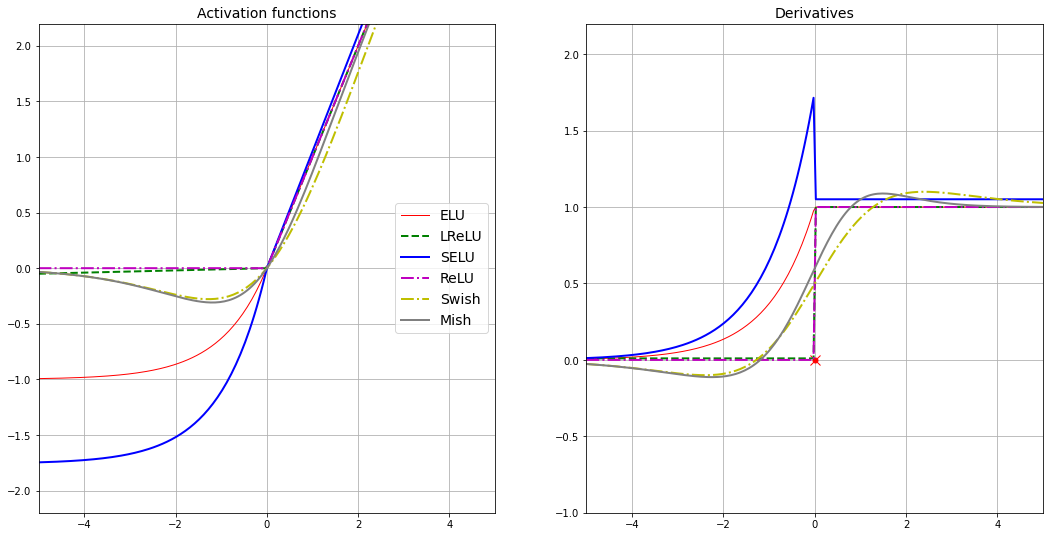

In [ ]:
#@title
import numpy as np
import matplotlib.pyplot as plt

def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

def relu(z):
    return np.maximum(0, z)

def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

from scipy.special import erfc
# alpha and scale to self normalize with mean 0 and standard deviation 1 (equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def swish(z):
    return z*sigmoid(z)

def mish(z, alpha=0.01):
    return z*np.tanh(np.log(1+np.exp(z)))

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)



z = np.linspace(-5, 5, 200)

plt.figure(figsize=(18,9))

plt.subplot(121)
plt.plot(z, elu(z), "r-", linewidth=1, label="ELU")
plt.plot(z, leaky_relu(z), "g--", linewidth=2, label="LReLU")
plt.plot(z, selu(z), "b-", linewidth=2, label="SELU")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.plot(z, swish(z), "y-.", linewidth=2, label="Swish")
plt.plot(z, mish(z), "gray", linewidth=2, label="Mish")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -2.2, 2.2])

plt.subplot(122)
plt.plot(z, derivative(elu, z), "r-", linewidth=1, label="ELU")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(leaky_relu, z), "g--", linewidth=2, label="LReLU")
plt.plot(z, derivative(selu, z), "b-", linewidth=2, label="SELU")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.plot(z, derivative(swish, z), "y-.", linewidth=2, label="Swish")
plt.plot(z, derivative(mish, z), "gray", linewidth=2, label="Mish")
plt.grid(True)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -1, 2.2])
plt.show()



### Post-proccesing methods

#### Non- Maximal Supression



The post-processing method commonly used in deep-learning-based object detection is *Non-Maximal-Suppresion* (NMS) (see notebook [Introduction to object detection](https://github.com/victorviro/Deep_learning_python/blob/master/Introduction_to_object_detection.ipynb)), which can be used to filter those  BBoxes that badly predict the same object, and only retain the candidate BBoxes with higher response. The standard for NMS is usually called *GreedyNMS*. The algorithm greedily selects high scoring detections and deletes close-by less confident neighbours since they are likely to cover the same object.

GreedyNMS makes hard decision by deleting detections and bases this decision on one fixed parameter (the thresold) which controls how wide the suppression is. A wide suppression would remove close-by high scoring detections that are likely to be false positives that hurt precision. However, if objects are close (crowded scenes), close-by detections can be true positives, in which case suppression should be narrow to improve recall. When objects are close-by, GreedyNMS is doomed to sacrifice precision or recall independent of its parameter.

![alt text](https://i.ibb.co/Vpw3t91/NMS.png)

The image above shows greedy-NMS results of different thresholds. The blue box shows the missing object, while the red ones highlight false positives. The bounding boxes in (b) are generated using Faster R-CNN. In a crowd scene, a lower NMS threshold may remove true positives (c) while a higher NMS threshold may increase false positives (d). The threshold for visualization is above 0.3. 


[Soft NMS](https://arxiv.org/abs/1704.04503) considers the problem that the occlusion of an object may cause the degradation of confidence score in greedy NMS with IoU score. 

![alt text](https://i.ibb.co/DC3KG3T/soft-NMS.png)

The image above shows detection results with soft-NMS (left) and NMS (right). The bounding box for the person in yellow is not miss deleted as redundant detection with soft-NMS.

The [DIoU NMS](https://arxiv.org/abs/1911.08287) adds the information of the center point distance to the BBox screening process on the basis of softNMS. 

It is worth mentioning that, since none of above post-processing methods directly refer to the captured image features, post-processing is no longer required in the subsequent development of an anchor-free method.



### Path-aggregation blocks

#### Feature Pyramid Network ([FPN](https://arxiv.org/abs/1612.03144))


Recognizing objects at different scales is a key challenge in computer vision. Feature pyramids built upon a pyramid of the same image at different scale (for short *featurized image pyramids*) form a standard solution (Figure (a)).

![texto alternativo](https://i.ibb.co/tYy03v0/featurized-image-pyramid.png)


These pyramids are scale-invariant in the sense that an object’s scale change is offset by shifting its level in the pyramid. This allows the model to detect objects across a large range of scales by scanning the model over both positions and pyramid levels. Featurized image pyramids were heavily used in the era of hand-engineered features. 


For recognition tasks, engineered features have  been replaced with features computed by deep convolutional networks (ConvNets). Aside from being capable of representing higher-level semantics, ConvNets are also more robust to variance in scale and thus facilitate recognition from features computed on a single input scale (Figure (b)).

![texto alternativo](https://i.ibb.co/SyN0c2Q/single-feature-map.png)

But even with this robustness, pyramids are still needed to get the most accurate results. One option is to use multi-scale testing on featurized image pyramids. The advantage of featurizing each level of an image pyramid is that it produces a multi-scale feature representation in which all levels are semantically strong, including the high-resolution levels.  But with this aproach, the inference time increases considerably and training deep networks end-to-end on an image pyramid is infeasible in
terms of memory, so image pyramids are used only at test time.

However, image pyramids are not the only way to compute a multi-scale feature representation. A deep ConvNet computes a feature hierarchy layer by layer, and with subsampling layers the feature hierarchy has an inherent multiscale, pyramidal shape. This in-network feature hierarchy
produces feature maps of different spatial resolutions but the high-resolution maps have low-level features that harm their representational capacity for object recognition.

![texto alternativo](https://i.ibb.co/8Dqy6Md/featurized-image-pyramid.png)

 

The Single Shot Detector ([SSD](https://arxiv.org/abs/1512.02325)) is an attempt at using a ConvNet’s pyramidal feature hierarchy as a featurized image pyramid (Figure below). The SSD-style pyramid reuse the multi-scale feature maps from different layers computed in the forward pass and thus come free of cost. But to avoid using low-level features which have no hight semantic value, SSD builds the pyramid starting from high up in the network. Thus it does not reuse the higher-resolution maps of the feature hierarchy which are important for detecting small objects.

![texto alternativo](https://i.ibb.co/vV5dCG2/SSD-pyramidal-feature-hierarchy.png)



Authors of the paper proposed a method called *Feature Pyramid Network* (FPN) which combines low-resolution, semantically strong features with high-resolution, semantically weak features via a top-down pathway and lateral connections (Figure (d)). The result is a feature pyramid that has rich semantics at all levels and is built quickly from a single input image scale. FPNs are able to achieve higher accuracy than all existing previous state-of-the-art methods. Moreover, this improvement is achieved without increasing testing time over the single-scale baseline. 

![texto alternativo](https://i.ibb.co/VBfHRS7/FPN.png)

FPN composes of a bottom-up and a top-down pathway.

**Bottom-up pathway**. It is the feedforward computation of the backbone ConvNet (the usual convolutional network for feature extraction), which computes a feature hierarchy consisting of feature maps at several scales. There are often many layers producing output maps of the same size and authors say these layers are in the same network *stage*. For the feature
pyramid, they define one pyramid level for each stage. They choose the output of the last layer of each stage as the reference set of feature maps, which we will enrich to create the pyramid (since the deepest layer
of each stage should have the strongest features).

**Top-down pathway and lateral connections**. The topdown pathway passes higher resolution features by upsampling spatially coarser, but semantically stronger, feature maps from higher pyramid levels. These features are
then enhanced with features from the bottom-up pathway via lateral connections. Each lateral connection merges feature maps of the same spatial size from the bottom-up pathway and the top-down pathway. The bottom-up feature map is of lower-level semantics, but its activations are more accurately localized as it was subsampled fewer times.




In this [video](https://youtu.be/jHv37mKAhV4?t=3014) one of the authors explains the method.



#### Path Aggregation Network ([PAN](https://arxiv.org/abs/1803.01534))

Path Aggregation Networks (PAN or PANet) is one version up of FPN. As we saw, the FPN uses a top-down path to extract and combine semantically rich features with the precise localization information. But for producing masks for large objects, this technique can be excessively lengthy as the spatial information may need to be propagated to hundreds of layers.

**Bottom-up Path Augmentation**: PANet on the other hand, takes an additional bottom-up path to the top-down path taken by FPN. This helps in shortening that path by using clean lateral connections from the lower layers to the top ones in order to propagate strong texture responses from low levels (useful to accurately localize instances) and fuse them directly with semantically rich responses present in $N_5$ (see figure). This is called the *shortcut* connection (dashed green line in Figure) which is only about 10 layers. In comparison, the CNN trunk in FPN gives a long path (dashed red line) passing through even 100+ layers from low layers to the topmost one.

![texto alternativo](https://i.ibb.co/xFJtnbm/PAN-bottom-up-path.png)

Following FPN, layers producing feature maps with the same spatial size are in the same network *stage*. Each feature level corresponds to one stage. Each building block takes a higher resolution feature map $N_i$, which goes through a convolutional layer to reduce the spatial size, and a coarser map $P_{i+1}$ through lateral connection. The fused feature map is then processed by another convolutional layer to generate $N_{i+1}$.

![texto alternativo](https://i.ibb.co/V2c23w8/building-block-bottom-up-path-aug.png)


**Adaptive Feature Pooling**: 


In FPN, an object proposal is assigned to one feature level according to the size of proposal. It makes small proposals assigned to low feature levels and large proposals to higher ones. This is simple, but it could lead undesired results. For example, two proposals with 10-pixel difference (rather similar) can be assigned to different levels. 

Moreover, information discarded in other levels may be helpful since importance of features may not be strongly correlated to the levels they belong to. High-level features capture richer context information and low-level features capture details and high localization accuracy. Allowing small proposals to access to high-levels features and large proposals to low-level ones is beneficial. 

PANet uses features from all the layers, and lets the network decide which ones are useful. It performs ROI Align operation on each feature map to extract the features for the object. This is followed by an element-wise max fusion operation to enable the network to adapt new features. This process is called  *adaptive feature pooling*. In following sub-networks, pooled feature grids go through one parameter layer independently, which is followed by the fusion operation, to enable network to adapt features.  For example, there are two fully connected layers ($\text{fc}$) in the box
branch in FPN.

![texto alternativo](https://i.ibb.co/Np9GG9Z/adaptative-feature-pooling.png)



**Fully-connected Fusion**: In Mask-RCNN, Fully Convolutional Network (FCN) is used instead of the fully-connected layers because it preserves the spatial information and reduces the number of parameters in the network. However, since the parameters are shared for all the spatial positions, the model doesn’t actually learn how to use pixel locations for making predictions. Fully-connected layers, on the other hand, are location sensitive and can adapt to different spatial locations.

PANet uses information from both these layers to provide a more accurate mask prediction.

![texto alternativo](https://i.ibb.co/4FPYyxH/mask-prediction-PANet.png)

As shown in the figure, the main path is a small FCN, which consists of 4 consecutive convolutional layers and 1 deconvolutional layer.  It predicts a binary pixel-wise mask for each class independently to decouple segmentation and classification, similar to that of Mask R-CNN. They also create a short path from layer conv3 to a fc layer. There are two convolutional layers where the second shrinks channels to half to reduce computational overhead. A fc layer is used to predict a class-agnostic foreground/background mask. The output vector of the fc layer is reshaped to the same spatial size as the mask predicted by FCN. To obtain the final mask prediction, mask of each class from FCN and foreground/background prediction from fc are added.

#### Others path-aggregation blocks

Since multi-scale prediction methods such as FPN have become popular, many lightweight modules that integrate different feature pyramid have been proposed. The modules of this sort include *Scale-wise Feature Aggregation Module* ([SFAM](https://arxiv.org/abs/1811.04533)), *Adaptively Spatial Feature Fusion* ([ASFF](https://arxiv.org/abs/1911.09516)), and *Bi-directional Feature Pyramid Network* ([BiFPN](https://arxiv.org/abs/1911.09070)). The main idea of SFAM is to use SE module to execute channel-wise level re-weighting on multi-scale concatenated feature maps. As for ASFF, it uses softmax as point-wise level re-weighting and then adds feature maps of different scales. In BiFPN, the multi-input weighted residual connections is proposed to execute scale-wise level re-weighting, and then add feature maps of different scales.

# References



- [Bag of Freebies for Training Object Detection Neural Networks](https://arxiv.org/abs/1902.04103)

- [YOLOv4](https://arxiv.org/pdf/2004.10934.pdf)

- [Learning Spatial Fusion for Single-Shot Object Detection](https://arxiv.org/abs/1911.09516)

- [Atrous_conv2d TensorFlow](https://www.tensorflow.org/api_docs/python/tf/nn/atrous_conv2d)


- [Learning non-maximum suppression](https://arxiv.org/abs/1705.02950)


- [Understanding FPN](https://medium.com/@jonathan_hui/understanding-feature-pyramid-networks-for-object-detection-fpn-45b227b9106c)

- [Understanding YOLOv4](https://medium.com/@jonathan_hui/yolov4-c9901eaa8e61)

- [YOLOv4 introduction](https://medium.com/visionwizard/yolov4-version-0-introduction-90514b413ccf)



